Some problems with the implementation proposed by Simeon Bamford:

-  the use of Euclidian distance -- we need to use Manhattan distance for my sake
-  Gaussian process for extracting $nProbConnect$ and others 
-  Source and target layers means either logical division (same "layers" on one core) or physical one with each layer on a different core
    
    
## Simulation Algorithm 1 Model Summary:

There are two layers of the size, the input and target layers; each is a square grid
of neurons with periodic boundaries, and the ideal location of each neuron in the input
layer is the location with the same coordinates in the target area. Each target-layer neuron
has the same number of potential synapses; these are dendritic locations in which actual
synapses may form; synapses can be with a pre-synaptic neuron from either the input or
target layer, including the post-synaptic neuron itself.

**Initial conditions**: all potential synapses start formed, with conductance $g_{max}$.

**Input**: neurons are independent Poisson processes. A stimulus location $s$ is randomly 
chosen and firing rates are set to 

$f_{base} + f_{peak}\times e^{-d / 2\sigma^{2}_{stim}}$
 
, where d is the distance from $s$. With a period $t_{sim}$, $s$ moves and the process repeats.

**Neuron dynamics (target-layer)**: the membrane voltage $V_{mem}$ is described by:

$\tau_{mem}\frac{\delta V_{mem}}{\delta t} = V_{rest} - V_{mem} + g_{ex}(t)(E_{ex}-V_{mem})$


$E_{ex}$ = excitatory reversal potential; $V_{rest}$ = resting potential; $\tau_{mem}$ = membrane time constant. Upon reaching a threshold $V_{thr}$, a spike occurs and $V_{mem}$ is reset to $V_{rest}$. A presynaptic
spike at time 0 causes a synaptic conductance at time $t \geq O$ of $g_{ex}(t) = ge^\frac{-t}{\tau_{ex}}(\tau_{ex}$= synaptic time constant); this is cumulative for all pre-synaptic spikes.

**STDP**: a pre-synaptic spike at time $t_{pre}$ and post-synaptic spike at $t_{post}$ modify the synaptic
conductance by $g —> g + g_{max}F(\Delta t)$,where $\Delta t = t_{pre}—t_{post}$ and $F(\Delta t) = A_{+}exp (\Delta t/T_{+})$ if
$\Delta t$ < 0, otherwise $F(\Delta t) = -A_{-}exp (-\Delta t/T_{-})$, where $A_{+/-}$ are magnitudes and 
$\tau_{+/-}$ are time constants for potentiation and depression respectively. This is cumulative for all pre and
post-synaptic spike pairs; g is bounded in (0, $g_{max}$).

**Synaptic rewiring**: At a fixed rate $f_{rew}$, a potential synapse is randomly chosen. If it is an
actual synapse, the elimination rule is used, otherwise the formation rule is used.

**Formation rule**: A possible pre-synaptic neuron is randomly selected from either the input
or target layer and synapse formation occurs if:

$r < p_{form}e^{-\frac{\delta^{2}}{2\sigma^2_{form}}}$

r = uniform random number in (0, 1); $p_{form}$ = peak formation probability;$\delta$ = distance of 
possible pre-synaptic neuron from ideal location of post-synaptic neuron; $\sigma_{form}$  = variance 
of the connection field. $p_{form}$ and $\sigma^2_{form}$ formmay differ based on which layer the possible presynaptic
neuron is from.

**Elimination rule**: If the synapse's conductance is below $0.5g_{max}$ it is eliminated with probability
$p_{elim-dep}$, otherwise probability $p_{elim-pot}$ is used
   

In [21]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.viridis()

### Layer representation

SpiNNaker represents synapses as a **sparse weight** matrix. 

Will represent incoming (pre-synaptic neurons) connections into the target layer as a **dense** matrix of pre-synaptic neurons. As such, will need to matrices for feed-forward and lateral connections.


In [58]:
# Simulation parameters TODO -- Sensitivity analysis

no_iterations = 3000000

# Wiring
n = 16
N_layer = n ** 2
S = (n, n)

s = (n//2, n//2)
s_max = 32
sigma_form_forward = 2.5
sigma_form_lateral = 1
p_form_lateral = 1
p_form_forward = 0.16
p_elim_dep = 0.0245
p_elim_pot = 1.36 * np.e ** -4
f_rew = 10 ** 4 #Hz

# Inputs
f_mean = 20 #Hz
f_base = 5 #Hz
f_peak = 152.8 #Hz
sigma_stim = 2
t_stim = 0.02 #s

# Membrane
v_rest = -70 #mV
e_ext = 0 #V
v_thr = -54 #mV
g_max = 0.2
tau_m = 20 #ms
tau_ex = 5 #ms

# STDP
a_plus = 0.1
b = 1.2
tau_plus = 20 #ms
tau_minus = 64 #ms

In [59]:
feed_forward_projections = np.zeros(S)
lateral_projections = np.zeros(S)

target_neuron_no_synapses = np.zeros(S)

### Periodic Boundries 

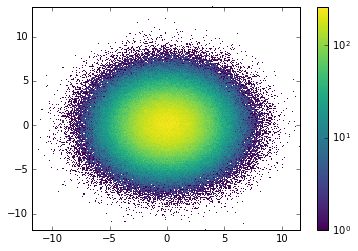

In [86]:
mu, sigma = 0, 2.5
distrox = np.random.normal(mu, sigma, 1000000)
distroy = np.random.normal(mu, sigma, 1000000)
# distro
from matplotlib.colors import LogNorm
plt.hist2d(distrox, distroy, bins=N, norm=LogNorm())
plt.colorbar()
plt.show()

In [108]:
def select_presynaptic_neuron(current_position, sigma):
    '''
    Function that returns the position of the desired presynaptic neuron based on the type of the projection
    (feed-forwards or lateral) and the associated parameters.
    '''
    return int(np.random.normal(current_position[0], sigma, 1))%n,\
           int(np.random.normal(current_position[1], sigma, 1))%n
    

def initialize():
#     for x, y in np.ndindex(S):
#         while target_neuron_no_synapses[x, y] < s_max:
#             ff = np.random.uniform(0, 1)
#             lat = np.random.uniform(0, 1)
#             if ff < p_form_forward:
#                 feed_forward_projections[select_presynaptic_neuron((x,y), sigma_form_forward)] = g_max
#                 target_neuron_no_synapses[x, y] += 1
#             if lat < p_form_lateral and target_neuron_no_synapses[x, y] < s_max:
#                 lateral_projections[select_presynaptic_neuron((x,y), sigma_form_forward)] = g_max
#                 target_neuron_no_synapses[x, y] += 1
    feed_forward_projections = np.ones(S) * g_max
    lateral_projections = np.ones(S) * g_max

    target_neuron_no_synapses = np.ones(S) * s_max
            
            

def create_synapse(source_location, target_location, projection):
    pass

In [106]:
initialize()

In [107]:
lateral_projections

array([[ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0.2,  0.2,  0.2],
       [ 0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,  0.2,
         0.2,  0.2,  0

### Simulation

In [111]:
def simulate(time_step = .1, iterations_left = no_iterations):
    initialize()
    time = 0
    while iterations_left:
        # Choose a stimulus location
        s = np.random.randint(0,16, 2)
        
        time += time_step
        iterations_left -= 1